In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from pydrake.geometry.optimization import HPolyhedron
from pydrake.geometry.optimization import VPolytope
from pydrake.geometry.optimization import CartesianProduct
from pydrake.solvers import MosekSolver
from pydrake.trajectories import PiecewisePolynomial

from gcs.bezier import BezierGCS
from gcs.linear import LinearGCS
from gcs.rounding import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# some helper functions for plotting cuboids
# https://stackoverflow.com/questions/49277753/plotting-cuboids
def edgecoord(pointx,pointy,pointz):
    edgex=[pointx[0],pointx[1],pointx[1],pointx[0]]
    edgey=[pointy[0],pointy[1],pointy[1],pointy[0]]
    edgez=[pointz[0],pointz[0],pointz[1],pointz[1]]
    return list(zip(edgex,edgey,edgez))

def coordConvert(x,y,lheight,uheight):
    if len(x) != len(y) and len(x)>2:
        return
    vertices=[]
    #Top layer
    vertices.append(list(zip(x,y,list(np.full(len(x),uheight)))))
    # Side layers
    for it in np.arange(len(x)):
        it1=it+1
        if it1>=len(x):
            it1=0
        vertices.append(edgecoord([x[it],x[it1]],[y[it],y[it1]],[lheight,uheight]))
    #Bottom layer
    vertices.append(list(zip(x,y,list(np.full(len(x),lheight)))))
    #print(vertices)
    #print(np.array(vertices))
    return vertices

# converts given 2 diagonal vertices of a rectangle and z bounds to numpy array of 8 points 
# assuming rectangles are parallel to x/y axes, we only need the diagonal two points
def V_2D_to_3D(x1, y1, x2, y2, z1, z2):
    return np.array([[x1, x1, x1, x1, x2, x2, x2, x2], 
                     [y1, y1, y2, y2, y1, y1, y2, y2],
                     [z1, z2, z1, z2, z1, z2, z1, z2]])

/tmp/ipykernel_2686/444915312.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


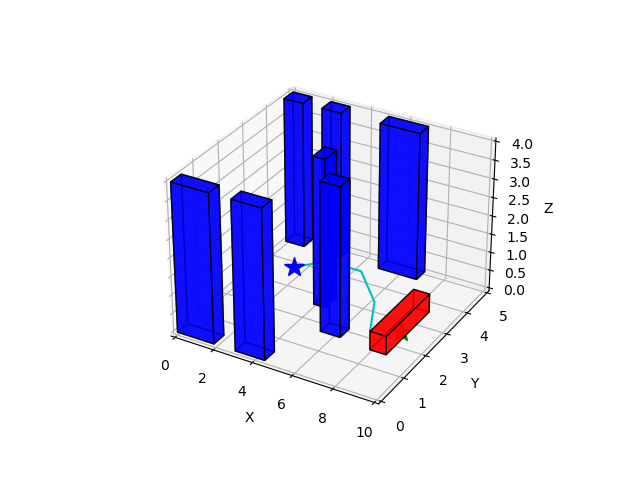

In [27]:
x_start = np.array([2.4, 3., 0.5])
x_goal = np.array([9.2, 1.8, 0.5])

z_min = 0
z_max = 4

convex_relaxation = True

# define free space regions using vertices.
# format is [[x1, ..., x8], [y1, ..., y8], [z1, ..., z8]]
# for the 8 points defigning a cuboid free-space region. 
# We can also include more vertices for a polyhedron.
# assuming rectangles are parallel to x/y axes, we only need the diagonal two points
V_dark_green = V_2D_to_3D(0.6, 1, 3.4, 4, z_min, z_max)
V_violet = V_2D_to_3D(0.6, 1.9, 4.8, 1, z_min, z_max)
V_pink = V_2D_to_3D(0.6, 4, 9.4, 3.6, z_min, z_max)
V_cyan = V_2D_to_3D(5.2, 4, 8, 2.6, z_min, z_max)
V_light_pink = V_2D_to_3D(7, 4, 8, 0.6, z_min, z_max)
V_dark_blue = V_2D_to_3D(9.4, 0.6, 5.1, 1, z_min, z_max)
V_neon_green = V_2D_to_3D(8, 4, 9.4, 3.5, z_min, z_max)
V_dark_red = V_2D_to_3D(9.4, 0.6, 8.8, 3.5, z_min, z_max)
V_purple = V_2D_to_3D(7, 1.5, 9.4, 1, z_min, z_max)
V_black = V_2D_to_3D(7.6, 4.4, 9.4, 3.6, z_min, z_max)
V_light_green = V_2D_to_3D(3.6, 4.4, 4.4, 3.6, z_min, z_max)

regions = [
    HPolyhedron(VPolytope(V_dark_green)),
    HPolyhedron(VPolytope(V_violet)),
    HPolyhedron(VPolytope(V_pink)),
    HPolyhedron(VPolytope(V_cyan)),
    HPolyhedron(VPolytope(V_light_pink)),
    HPolyhedron(VPolytope(V_dark_blue)),
    HPolyhedron(VPolytope(V_neon_green)),
    HPolyhedron(VPolytope(V_dark_red)),
    HPolyhedron(VPolytope(V_purple)),
    HPolyhedron(VPolytope(V_black)),
    HPolyhedron(VPolytope(V_light_green))
]


fig = plt.figure()  
ax = fig.add_subplot(111, projection='3d')  
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim(0, 10)
ax.set_ylim(0, 5)
ax.set_zlim(0, 4)

b_gcs = BezierGCS(regions, order=5, continuity=2)
b_gcs.addTimeCost(1)
b_gcs.addPathLengthCost(1)
b_gcs.addSourceTarget(x_start, x_goal)
b_gcs.setSolver(MosekSolver())
bezier_traj = b_gcs.SolvePath(convex_relaxation)[0]

samples = np.linspace(bezier_traj.start_time(), bezier_traj.end_time())
values = np.squeeze([bezier_traj.value(s) for s in samples])
plt.plot(values[:, 0], values[:, 1],  values[:, 2], "c-")

# plot start and end points
plt.plot(x_start[0], x_start[1], x_start[2], 'b*', markersize=15)
plt.plot(x_goal[0], x_goal[1], x_goal[2], 'g*', markersize=15)

# obstacle vertices (points have to be in counter-clockwise order)
obst1 = coordConvert([0, 1.9, 1.9, 0], [0, 0, 0.4, 0.4], z_min, z_max)
obst2 = coordConvert([3, 4.5, 4.5, 3], [0, 0, 0.4, 0.4], z_min, z_max)
obst3 = coordConvert([0, 1, 1, 0], [4.6, 4.6, 5, 5], z_min, z_max)
obst4 = coordConvert([2, 3, 3, 2], [4.6, 4.6, 5, 5], z_min, z_max)
obst5 = coordConvert([5, 7, 7, 5], [4.6, 4.6, 5, 5], z_min, z_max)
obst6 = coordConvert([4, 4.6, 4.6, 4], [2.5, 2.5, 3, 3], z_min, z_max)
obst7 = coordConvert([5.4, 6.4, 6.4, 5.4], [1.6, 1.6, 2, 2], z_min, z_max)
obst_person = coordConvert([8, 8.8, 8.8, 8], [1.5, 1.5, 3.5, 3.5], z_min, 0.5)

plt.gca().add_collection3d(Poly3DCollection(obst1, alpha=.75,edgecolor='k', facecolor='blue'))
plt.gca().add_collection3d(Poly3DCollection(obst2, alpha=.75,edgecolor='k', facecolor='blue'))
plt.gca().add_collection3d(Poly3DCollection(obst3, alpha=.75,edgecolor='k', facecolor='blue'))
plt.gca().add_collection3d(Poly3DCollection(obst4, alpha=.75,edgecolor='k', facecolor='blue'))
plt.gca().add_collection3d(Poly3DCollection(obst5, alpha=.75,edgecolor='k', facecolor='blue'))
plt.gca().add_collection3d(Poly3DCollection(obst6, alpha=.75,edgecolor='k', facecolor='blue'))
plt.gca().add_collection3d(Poly3DCollection(obst7, alpha=.75,edgecolor='k', facecolor='blue'))
plt.gca().add_collection3d(Poly3DCollection(obst_person, alpha=.75,edgecolor='k', facecolor='red'))
